In [1]:
# Importar SparkSession da biblioteca PySpark
from pyspark.sql import SparkSession

# Inicializar a sessão Spark
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [2]:
# Caminho para o arquivo CSV
csv_file = "/user/user1/Maternal_Health_Risk.csv"

# Carregar o arquivo CSV em um DataFrame Spark
df = spark.read.format("csv") \
             .option("inferSchema", "true") \
             .option("header", "true") \
             .load(csv_file)

# Criar uma visualização temporária para o DataFrame
df.createOrReplaceTempView("rawdata")

In [3]:
# Visualizar o esquema inferido
df.printSchema()

# Exibir as primeiras linhas dos dados
df.show(5)

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
+---+----------+-----------+----+--------+---------+---------+
only showing top 5 rows



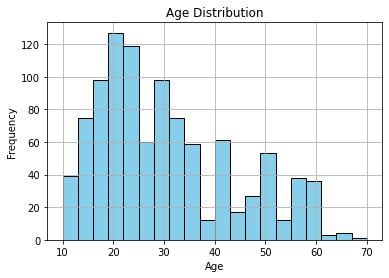

In [6]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("health_data")

# Extract age data using Spark SQL
age_data = spark.sql("SELECT Age FROM health_data").rdd.flatMap(lambda x: x).collect()

# Plot age distribution
plt.hist(age_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("health_data")

# Age Distribution Analysis
age_distribution_query = """
    SELECT Age, COUNT(*) AS Frequency
    FROM health_data
    GROUP BY Age
    ORDER BY Age
"""

age_distribution = spark.sql(age_distribution_query)

# Display age distribution
age_distribution.show()

+---+---------+
|Age|Frequency|
+---+---------+
| 10|        4|
| 12|       35|
| 13|       12|
| 14|        3|
| 15|       60|
| 16|       16|
| 17|       63|
| 18|       19|
| 19|       67|
| 20|       22|
| 21|       38|
| 22|       45|
| 23|       71|
| 24|        3|
| 25|       48|
| 26|        3|
| 27|        9|
| 28|       28|
| 29|       40|
| 30|       30|
+---+---------+
only showing top 20 rows



In [12]:
# Age-Risk Relationship Analysis
age_risk_query = """
    SELECT
        CASE WHEN Age <= 20 THEN '0-20'
             WHEN Age BETWEEN 21 AND 30 THEN '21-30'
             WHEN Age BETWEEN 31 AND 40 THEN '31-40'
             WHEN Age BETWEEN 41 AND 50 THEN '41-50'
             ELSE 'Above 50' END AS Age_Group,
        AVG(CASE WHEN RiskLevel = 'low risk' THEN 1 ELSE 0 END) AS Low_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'mid risk' THEN 1 ELSE 0 END) AS Mid_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'high risk' THEN 1 ELSE 0 END) AS High_Risk_Avg
    FROM health_data
    GROUP BY Age_Group
    ORDER BY Age_Group
"""

age_risk_relationship = spark.sql(age_risk_query)

# Display Age-Risk Relationship
age_risk_relationship.show()

+---------+-------------------+-------------------+-------------------+
|Age_Group|       Low_Risk_Avg|       Mid_Risk_Avg|      High_Risk_Avg|
+---------+-------------------+-------------------+-------------------+
|     0-20| 0.4983388704318937|0.37209302325581395|0.12956810631229235|
|    21-30|0.43174603174603177| 0.3904761904761905|0.17777777777777778|
|    31-40| 0.2677595628415301|0.23497267759562843| 0.4972677595628415|
|    41-50|0.31666666666666665|              0.275| 0.4083333333333333|
| Above 50| 0.3473684210526316| 0.2631578947368421| 0.3894736842105263|
+---------+-------------------+-------------------+-------------------+



In [15]:
# Blood Pressure-Risk Relationship Analysis
bp_risk_query = """
    SELECT 
        CASE
            WHEN SystolicBP <= 120 AND DiastolicBP <= 80 THEN 'Normal'
            WHEN SystolicBP > 120 AND SystolicBP <= 129 AND DiastolicBP <= 80 THEN 'Elevated'
            WHEN SystolicBP >= 130 AND SystolicBP <= 139 OR DiastolicBP >= 80 AND DiastolicBP <= 89 THEN 'Stage 1 High'
            WHEN SystolicBP >= 140 OR DiastolicBP >= 90 THEN 'Stage 2 High'
            ELSE 'Other' 
        END AS BP_Category,
        AVG(CASE WHEN RiskLevel = 'low risk' THEN 1 ELSE 0 END) AS Low_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'mid risk' THEN 1 ELSE 0 END) AS Mid_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'high risk' THEN 1 ELSE 0 END) AS High_Risk_Avg
    FROM health_data
    GROUP BY BP_Category
"""

bp_risk_relationship = spark.sql(bp_risk_query)

# Display Blood Pressure-Risk Relationship
bp_risk_relationship.show()


+------------+-------------------+------------------+------------------+
| BP_Category|       Low_Risk_Avg|      Mid_Risk_Avg|     High_Risk_Avg|
+------------+-------------------+------------------+------------------+
|Stage 2 High|0.25660377358490566|               0.2|0.5433962264150943|
|Stage 1 High|0.20161290322580644|0.5483870967741935|              0.25|
|      Normal|             0.5008|             0.344|            0.1552|
+------------+-------------------+------------------+------------------+



Esses resultados representam a proporção média de cada nível de risco (baixo, médio e alto) dentro de diferentes categorias de pressão arterial.

BP_Category: Indica as categorias de pressão arterial, como "Normal", "Elevated", "Stage 1 High" e "Stage 2 High".
Low_Risk_Avg: Representa a média da proporção de casos de baixo risco dentro de cada categoria de pressão arterial. Por exemplo, na categoria "Normal", a média de casos de baixo risco é de aproximadamente 50.08%.
Mid_Risk_Avg: Representa a média da proporção de casos de risco moderado dentro de cada categoria de pressão arterial. Por exemplo, na categoria "Stage 1 High", a média de casos de risco moderado é de aproximadamente 54.84%.
High_Risk_Avg: Representa a média da proporção de casos de alto risco dentro de cada categoria de pressão arterial. Por exemplo, na categoria "Stage 2 High", a média de casos de alto risco é de aproximadamente 54.34%.
Esses resultados ajudam a entender como os diferentes níveis de pressão arterial estão relacionados aos diferentes níveis de risco de saúde. Por exemplo, parece haver uma tendência de aumento do risco à medida que a pressão arterial aumenta, o que é evidenciado pelas proporções mais altas de casos de alto risco nas categorias de pressão arterial mais elevada.



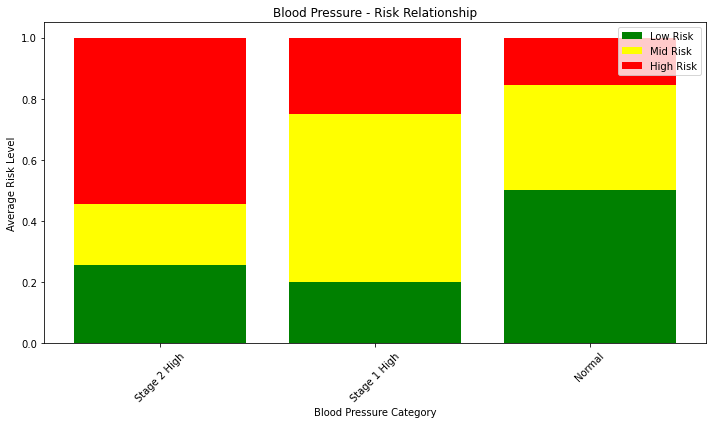

In [16]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
bp_risk_relationship_pd = bp_risk_relationship.toPandas()

# Create the bar chart
plt.figure(figsize=(10, 6))

# Plot the low-risk averages
plt.bar(bp_risk_relationship_pd['BP_Category'], bp_risk_relationship_pd['Low_Risk_Avg'], color='green', label='Low Risk')

# Plot the mid-risk averages
plt.bar(bp_risk_relationship_pd['BP_Category'], bp_risk_relationship_pd['Mid_Risk_Avg'], color='yellow', label='Mid Risk', bottom=bp_risk_relationship_pd['Low_Risk_Avg'])

# Plot the high-risk averages
plt.bar(bp_risk_relationship_pd['BP_Category'], bp_risk_relationship_pd['High_Risk_Avg'], color='red', label='High Risk', bottom=bp_risk_relationship_pd['Low_Risk_Avg'] + bp_risk_relationship_pd['Mid_Risk_Avg'])

# Add labels and legends
plt.xlabel('Blood Pressure Category')
plt.ylabel('Average Risk Level')
plt.title('Blood Pressure - Risk Relationship')
plt.legend()

# Show the chart
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

In [25]:
# Display the first few rows of the DataFrame
print(pandas_df.head())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [23]:
# Check for missing values
missing_values = pandas_df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [24]:
# Remove duplicate rows
pandas_df.drop_duplicates(inplace=True)

# Evaluate outliers or handle anomalous values
# This may involve statistical calculations or visualizations to identify anomalous values

# Display the first few rows of the DataFrame after transformations
print("\nDataFrame after transformations:\n", pandas_df.head())


DataFrame after transformations:
    Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


- Certo, aqui está um exemplo de como integrar pipelines, validação cruzada, redes neurais e regressão no seu projecto:

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-04-05 10:07:24.825285: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 10:07:26.515070: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 10:07:32.043395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 10:07:44.889115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [48]:
pandas_df.replace({' low risk': 0, 'mid risk': 1, 'high risk': 2}, inplace=True)
pandas_df.drop_duplicates(inplace=True)

In [49]:
X = pandas_df[['Age', 'BodyTemp', 'HeartRate']].values
y = pandas_df['RiskLevel'].values

In [50]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [52]:
ffnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

NameError: name 'tf' is not defined

Define helper functions to calculate performance metrics

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    matthew = matthews_corrcoef(y_test, y_pred)[0][1]

    print("Performance Metrics: \n")
    print("Accuracy: ", acc)
    print("Precision: ", prec)
    print("Recall: ", rec)
    print("F1 Score: ", f1)
    print("Balanced Accuracy: ", bal_acc)
    print("Matthews correlation coefficient: ", matthew)

Perform train-test splitting:

In [42]:
X = pandas_df[['Age', 'BodyTemp', 'HeartRate']].values
y = pandas_df['RiskLevel'].apply(lambda x: 'low' if x==' low risk' else 'moderate' if x=='mid risk' else 'high').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply Standardization:

In [43]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Build and train a single FeedForward Neural Network

In [45]:
ffnn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, alpha=1e-4, solver='adam', verbose=0)
prec = precision_score(y_test, y_pred, average='binary', pos_label='high')

NameError: name 'y_pred' is not defined

Build and train a Stacked Generalization Model